<img src="../data/ml-latest-small/tmdb_blue_logo.svg" alt="tmdb logo" width="200"/> In this notebook, we use the API for [The Movie Database (TMDb)](https://developers.themoviedb.org/3/getting-started/introduction) to retrieve information about the movies contained in the Movie Len dataset that we use for testing the recommendation engines.

In [82]:
import io
import os
import csv
import json
import itertools as it
from pprint import pprint
from collections import defaultdict

import numpy as np
import requests
from PIL import Image
from dotenv import find_dotenv, load_dotenv
from ratelimit import limits, sleep_and_retry

In [2]:
@sleep_and_retry
@limits(calls=40, period=10)  # TMDb limits to 40 requests per 10 seconds.
def call_api(url):
    response = requests.get(url)

    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    return response

In [3]:
_ = load_dotenv(find_dotenv())

In [4]:
API_KEY = os.getenv("TMDB_API")

In [88]:
link_filename = "../data/ml-latest-small/links.csv"
item_id_lookup = defaultdict()

with open(link_filename, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        item_id_lookup[int(row["movieId"])] = row["tmdbId"]
        
all_movie_ids = list(set(item_id_lookup.keys()))

In [92]:
movie_id = item_id_lookup[np.random.choice(all_movie_ids)]

In [93]:
get_info = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={API_KEY}&append_to_response=recommendations,similar"

In [94]:
response = call_api(get_info)

In [95]:
info = response.json()

In [96]:
info.keys()

dict_keys(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'recommendations', 'similar'])

In [97]:
# [similar][results] is a list and has 20 elements
info["similar"]["results"][0].keys()

dict_keys(['adult', 'backdrop_path', 'genre_ids', 'id', 'original_language', 'original_title', 'overview', 'poster_path', 'release_date', 'title', 'video', 'vote_average', 'vote_count', 'popularity'])

In [98]:
configuration = call_api(f"https://api.themoviedb.org/3/configuration?api_key={API_KEY}").json()

In [99]:
pprint(configuration["images"])

{'backdrop_sizes': ['w300', 'w780', 'w1280', 'original'],
 'base_url': 'http://image.tmdb.org/t/p/',
 'logo_sizes': ['w45', 'w92', 'w154', 'w185', 'w300', 'w500', 'original'],
 'poster_sizes': ['w92', 'w154', 'w185', 'w342', 'w500', 'w780', 'original'],
 'profile_sizes': ['w45', 'w185', 'h632', 'original'],
 'secure_base_url': 'https://image.tmdb.org/t/p/',
 'still_sizes': ['w92', 'w185', 'w300', 'original']}


In [100]:
img_url = (
    configuration["images"]["secure_base_url"] + 
    configuration["images"]["poster_sizes"][3] + 
    info["poster_path"]
)

resp = call_api(img_url)
img = Image.open(io.BytesIO(resp.content))

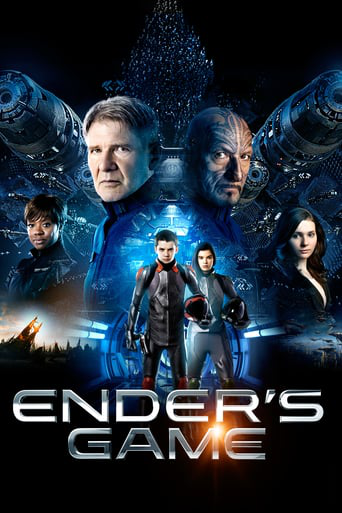

In [101]:
img

# Data Exploration

In [ ]:
# movie rating dataset
df = pd.read_csv("../data/ml-latest-small/ratings.csv")
print("Number of interactions in dataset: ",len(df), "\n")
df.head()

Because we don't yet have the ability to handle sequences or time series in our recommendation, we will leave out the timestamp information for now.

In [ ]:
unique_movies = {x for x in df.movieId}
print(f"Number of unique movies {len(unique_movies)}")
unique_users = {x for x in df.userId}
print(f"Number of unique users {len(unique_users)}")
print(f"The sparsity of the user-movie interaction matrix is {(100 * len(df) / (len(unique_movies) * len(unique_users))):.2f} %")

# for the recommendation engine, we need user_id, item_id, and interactions
df = df[["userId", "movieId", "rating"]]
df.columns = ["user_id", "item_id", "interactions"]
df.head()

In [ ]:
df_grouped = df[["item_id", "interactions"]].groupby(["item_id"]).count()
df_grouped.reset_index(inplace=True)
most_watched = df_grouped.sort_values(by='interactions', ascending=False)
df_grouped = df[["item_id", "interactions"]].groupby(["item_id"]).mean()
df_grouped.reset_index(inplace=True)
highest_rated = df_grouped.sort_values(by='interactions', ascending=False)
print(
    f"5 Most Watched Movies:\n{most_watched.head(5)}\n\n"
    f"5 Highest Rated Movies:\n{highest_rated.head(5)}"
)

In [ ]:
# OK, so it would be nice if we knew what movies these IDs are associated with.
df_movies = pd.read_csv("../data/ml-latest-small/movies.csv")
df_movies = df_movies.iloc[:,0:2]
df_movies.head()

# Now we convert the movie_id and title into a dictionary mapping ids to titles.
movie_dict = dict(zip(df_movies.movieId, df_movies.title))

most_watched["title"] = most_watched.item_id.map(movie_dict)
most_watched.head(10)

highest_rated["title"] = highest_rated.item_id.map(movie_dict)
highest_rated.head(10)